In [2]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    

import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

In [3]:
# from breaching.cases.models.custom_models import McMahan_32_32
# from breaching.attacks.auxiliaries.mask_functions import mask_percentage_in_channels, mask_percentage_out_channels
# import torch.nn as nn
# import torch

# net = McMahan_32_32()
# images = torch.rand((4, 3, 32, 32))
# labels = nn.functional.one_hot(torch.randint(0, 9, size=(4,)), num_classes=10).float()
# output = net(images)
# loss = nn.CrossEntropyLoss()(output, labels)
# grad = torch.autograd.grad(loss, net.parameters())


# p = 1./2.
# mask_fn = mask_percentage_in_channels(p)
# mask_fn._generate_mask(grad)
# for mask in mask_fn.fixed_mask:
#     print(mask)

### Initialize cfg object and system setup:

In [4]:
import hydra
from omegaconf import OmegaConf, open_dict
from hydra import initialize, compose

with initialize(config_path="../breaching/config", version_base="1.1"):
    cfg = compose(config_name="Adam_cfg", overrides=["+experiment=flp_oneshot_attack"])
with open_dict(cfg):
    cfg.case.user.provide_labels = False
    cfg.case.user.provide_local_hyperparams = False
    cfg.attack.label_strategy = "yin"
cfg.seed = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

{'device': device(type='cuda', index=0), 'dtype': torch.float32}

In [5]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture custom_McMahan_32_32 loaded with 2,156,490 parameters and 0 buffers.
Overall this is a data ratio of       7:1 for target shape [100, 3, 32, 32] given that num_queries=1.
User (of type UserMultiStep) with settings:
    Number of data points: 100

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 0
    
        
    Local FL Setup:
        Number of local update steps: 5
        Data per local update step: 20
        Local learning rate: 0.01

        Threat model:
        Share these hyperparams to server: False

        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: custom_McMahan_32_32
        model state: default
        

    Secrets: {}
    
Attacker (of type Opt

Computing user update on user 0 in model mode: eval.


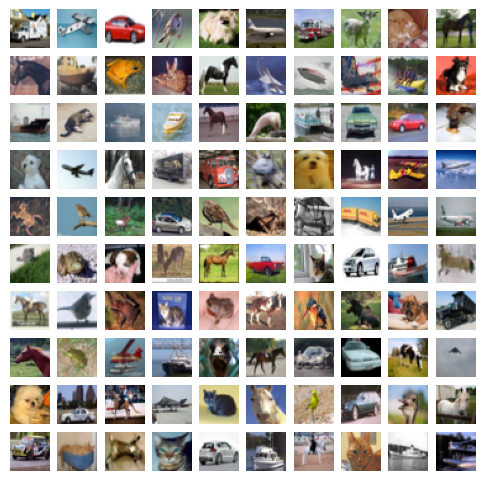

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
user.plot(true_user_data)

In [12]:
print(shared_data.keys())
shared_data["gradients"][-2].min(-1)[0]

dict_keys(['gradients', 'buffers', 'metadata'])


tensor([-0.0001, -0.0001, -0.0002, -0.0002, -0.0009, -0.0004, -0.0009, -0.0001,
        -0.0004, -0.0007], device='cuda:0')

In [9]:
print(true_user_data.keys())
print(true_user_data['labels'])
print(true_user_data['labels'].sort())
step = 4
label_list = []
seen_data_idx = 0
for i in range(step):
    data = {
        k: v[seen_data_idx:seen_data_idx + 20] for k, v in true_user_data.items()
    }
    seen_data_idx += 20
    seen_data_idx = seen_data_idx % 10
    label_list.append(data["labels"].sort()[0])
for i in range(len(label_list)):
    print("labels", label_list[i])

dict_keys(['data', 'labels', 'buffers'])
tensor([0, 9, 1, 7, 8, 3, 2, 1, 2, 7, 7, 8, 6, 8, 9, 5, 2, 3, 8, 9, 6, 9, 7, 2,
        3, 6, 8, 7, 5, 6, 6, 6, 5, 7, 8, 1, 3, 0, 1, 4, 3, 4, 9, 8, 6, 9, 3, 6,
        0, 6, 6, 6, 1, 9, 8, 8, 7, 8, 2, 9, 1, 2, 9, 4, 6, 1, 4, 5, 2, 3, 0, 0,
        9, 9, 9, 2, 5, 9, 5, 8, 0, 8, 3, 9, 4, 0, 6, 6, 4, 5, 2, 4, 6, 0, 6, 6,
        1, 8, 4, 3], device='cuda:0')
torch.return_types.sort(
values=tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
        5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
        7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9], device='cuda:0'),
indices=tensor([70, 80, 85, 71, 93,  0, 37, 48, 60,  7, 35, 38, 52, 96, 65,  2, 90, 61,
         6, 58,  8, 23, 16, 75, 68, 46, 82, 99, 69, 40, 36, 24,  5, 17, 63, 88,
        84, 66, 98, 91, 41, 39, 89, 78, 76

In [7]:
print(shared_data.keys())
print(shared_data["metadata"].keys())
print(shared_data["metadata"]["local_hyperparams"].keys())
print("labels", shared_data["metadata"]["labels"])
gradients = shared_data["gradients"]
labels = shared_data["metadata"]["local_hyperparams"]["labels"]
for i in range(len(gradients)):
    print("gradients", gradients[i].shape)
for i in range(len(labels)):
    print("labels", labels[i])

dict_keys(['gradients', 'buffers', 'metadata'])
dict_keys(['num_data_points', 'labels', 'local_hyperparams', 'data_key'])


AttributeError: 'NoneType' object has no attribute 'keys'

In [8]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

Recovered labels [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9] through strategy yin.


| It: 1/2400 | Rec. loss: 5.4096e-01 | Task loss: 2.3260e+00 | T: 0.20s
| It: 101/2400 | Rec. loss: 1.1511e-02 | Task loss: 2.3009e+00 | T: 3.58s
| It: 201/2400 | Rec. loss: 5.6322e-03 | Task loss: 2.3042e+00 | T: 2.17s
| It: 301/2400 | Rec. loss: 4.5650e-03 | Task loss: 2.3043e+00 | T: 2.18s
| It: 401/2400 | Rec. loss: 4.1006e-03 | Task loss: 2.3041e+00 | T: 2.18s
| It: 501/2400 | Rec. loss: 4.4649e-03 | Task loss: 2.3052e+00 | T: 2.18s
| It: 601/2400 | Rec. loss: 4.3750e-03 | Task loss: 2.3043e+00 | T: 2.18s
| It: 701/2400 | Rec. loss: 4.2269e-03 | Task loss: 2.3043e+00 | T: 2.19s
| It: 801/2400 | Rec. loss: 4.0333e-03 | Task loss: 2.3040e+00 | T: 2.20s
| It: 901/2400 | Rec. loss: 4.2320e-03 | Task loss: 2.3044e+00 | T: 2.20s
| It: 1001/2400 | Rec. loss: 4.2767e-03 | Task loss: 2.3037e+00 | T: 2.21s
| It: 1101/2400 | Rec. loss: 4.2068e-03 | Task loss: 2.3047e+00 | T: 2.21s
| It: 1201/2400 | Rec. loss: 4.1644e-03 | Task loss: 2.3042e+00 | T: 2.21s
| It: 1301/2400 | Rec. loss: 4.0216e-

In [11]:
import torch.nn.functional as F
from omegaconf import open_dict
with open_dict(cfg):
    cfg.case.data.vocab_size = 100 # issue if not setup
# temp_rec_data = {
#     "data": F.pad(reconstructed_user_data["data"], (2, 2, 2, 2), mode="constant", value=0),
#     "labels": reconstructed_user_data["labels"],
# }
# temp_true_data = {
#     "data": F.pad(true_user_data["data"], (2, 2, 2, 2), mode="constant", value=0),
#     "labels": true_user_data["labels"]
# }
temp_rec_data = reconstructed_user_data
temp_true_data = true_user_data
print(temp_rec_data["data"].shape, temp_true_data["data"].shape)
metrics = breaching.analysis.report(
    temp_rec_data, 
    temp_true_data,
    [server_payload], 
    server.model,
    order_batch=True,
    compute_full_iip=False, 
    cfg_case=cfg.case,
    setup=setup,
)

torch.Size([100, 3, 32, 32]) torch.Size([100, 3, 32, 32])
Starting evaluations for attack effectiveness report...


METRICS: | MSE: 0.0667 | PSNR: 12.36 | FMSE: 7.7560e-03 | LPIPS: 0.39|
 R-PSNR: 13.02 | IIP-none:  nan% | SSIM: 0.1942 | max R-PSNR: 19.34 | max SSIM: 0.2945 | Label Acc: 81.00%


In [136]:
mse_mean = 0
mse_var = 0
n = 30
for i in range(n):
    mse_mean += results["mask_clip"]["0.1"][i]["mse"]
mse_mean /= n

for i in range(n):
    mse_var += (results["mask_clip"]["0.1"][i]["mse"] - mse_mean)**2
mse_var /= n

print(mse_mean)
print(n * mse_var / (n-1))

0.1125494360923767
0.0004039836067923969


### Simulate an attacked FL protocol

In [31]:
import pickle

save_path_fixed_layer = "./testing/results_mask_fixed_layer.pickle"
with open(save_path_fixed_layer, 'rb') as file:
    saved_dico_fixed_layer = pickle.load(file)
print(saved_dico_fixed_layer.keys())
print(saved_dico_fixed_layer['mask_fixed_layer'].keys())
print()

save_path_big = "./testing/results_mask_big.pickle"
with open(save_path_big, 'rb') as file:
    saved_dico_big = pickle.load(file)
saved_dico_big["mask_fixed_layer_random_1"] = saved_dico_big.pop("mask_fixed_layer")
print(saved_dico_big.keys())
print(saved_dico_big['mask_fixed_layer_random_1'].keys())


dict_keys(['mask_fixed_layer'])
dict_keys(['(0,)', '(1,)', '(2,)', '(3,)', '(4,)', '(5,)', '(6,)', '(7,)', '(0, 1)', '(0, 1, 2)', '(0, 1, 2, 3)', '(0, 1, 2, 3, 4)', '(0, 1, 2, 3, 4, 5)', '(0, 1, 2, 3, 4, 5, 6)', '(7, 6, 5, 4, 3, 2, 1)', '(7, 6, 5, 4, 3, 2)', '(7, 6, 5, 4, 3)', '(7, 6, 5, 4)', '(7, 6, 5)', '(7, 6)', '(0, 1, 2, 3, 4, 5, 6, 7)'])

dict_keys(['mask_fixed_identity', 'mask_fixed_bernoulli', 'mask_clip', 'mask_fixed_layer_random_1'])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [32]:
import copy

def average_metrics_trials(metrics, num_trials=None):
    """Metrics' Dict Structure:
    trial - metrics
    """
    if num_trials is None:
        num_trials = len(metrics.keys())
    res_dico = {}
    for i in range(num_trials):
        for key in metrics[i].keys():
            if key in res_dico:
                res_dico[key] += metrics[i][key]
            else:
                res_dico[key] = copy.deepcopy(metrics[i][key])
    for key in res_dico.keys():
        if key != "order":
            res_dico[key] /= num_trials
    return res_dico

def summarize_score_trials(metrics):
    """Metrics' Dict Stucture:
    First type: key1 - key2 - trial - metrics
    Second type: key1 - trial - metrics
    """
    average_dico = {}
    for key1 in metrics.keys():
        average_dico[key1] = {}
        simpler_metrics = []
        for key2 in metrics[key1].keys():
            if not key2 in range(10):
                average_dico[key1][key2] = average_metrics_trials(metrics[key1][key2])
            else:
                simpler_metrics.append(metrics[key1][key2])

        if simpler_metrics != []:
            average_dico[key1]["avg"] = breaching.utils.avg_n_dicts(simpler_metrics)
    return average_dico

average_dico_fixed_layer = summarize_score_trials(saved_dico_fixed_layer)
average_dico_big = summarize_score_trials(saved_dico_big)

In [14]:
def extract_one_metric(average_dico, metric):
    res_key = []
    for key1 in average_dico.keys():
        for key2 in average_dico[key1].keys():
            if not (key1 == "mask_fixed_bernoulli" and key2 == "avg"):
                res_key.append(average_dico[key1][key2][metric])
    return res_key

print(len(tuple(extract_one_metric(average_dico_fixed_layer, "mse"))))

21


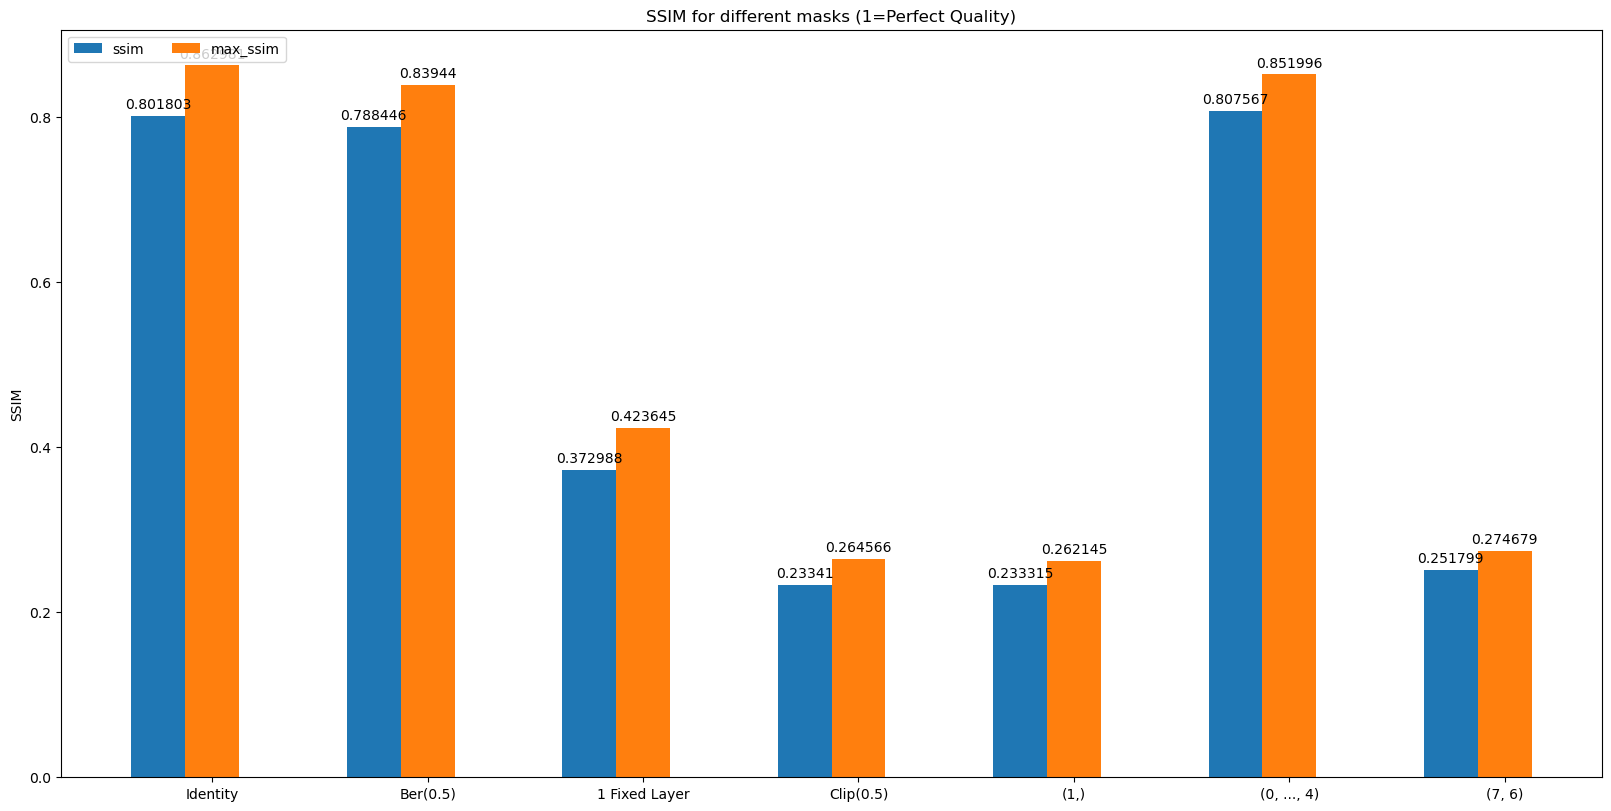

In [38]:
import matplotlib.pyplot as plt
import numpy as np

"dict_keys(['mse', 'psnr', 'lpips', 'rpsnr', 'ssim', 'max_ssim', 'max_rpsnr', 'order', 'IIP-pixel', 'feat_mse', 'parameters', 'label_acc'])"

_slice_bernoulli_big = range(1, 1+9)
_slice_clip_big = range(11, 11+9)
_slice_mean_big = [0, 5, 10, 15]

_slice_all_fixed_layer = range(len(extract_one_metric(average_dico_fixed_layer, "mse")))
_slice_mean_fixed_layer = [1, 11, 19]

_slice_mean_all = _slice_mean_big + [i + 20 for i in _slice_mean_fixed_layer]

_slice = _slice_mean_all

species_big = (
    ("Identity",) 
    + ("Ber(0.1)", "Ber(0.2)", "Ber(0.3)", "Ber(0.4)", "Ber(0.5)", "Ber(0.6)", "Ber(0.7)", "Ber(0.8)", "Ber(0.9)")
    + ("1 Fixed Layer",) 
    + ("Clip(0.1)", "Clip(0.2)", "Clip(0.3)", "Clip(0.4)", "Clip(0.5)", "Clip(0.6)", "Clip(0.7)", "Clip(0.8)", "Clip(0.9)")
)
species_fixed = (
    ('(0,)', '(1,)', '(2,)', '(3,)', '(4,)', '(5,)', '(6,)', '(7,)')
    + ('(0, 1)', '(0, 1, 2)', '(0, ..., 3)', '(0, ..., 4)', '(0, ..., 5)', '(0, ..., 6)')
    + ('(7, ..., 1)', '(7, ..., 2)', '(7, ..., 3)', '(7, ..., 4)', '(7, 6, 5)', '(7, 6)')
    + ('(0, ..., 7)',)
)

species = species_big + species_fixed
species = [species[i] for i in _slice]

average_dico = average_dico_big | average_dico_fixed_layer
penguin_means = {
    # 'mse': tuple(extract_one_metric(average_dico, "mse")),
    # 'psnr': tuple(extract_one_metric(average_dico, "psnr")),
    # 'lpips': tuple(extract_one_metric(average_dico, "lpips")),
    # 'rpsnr': tuple(extract_one_metric(average_dico, "rpsnr")),
    'ssim': tuple(extract_one_metric(average_dico, "ssim")),
    'max_ssim': tuple(extract_one_metric(average_dico, "max_ssim")),
    # 'max_rpsnr': tuple(extract_one_metric(average_dico, "max_rpsnr")),
    # 'IIP-pixel': tuple(extract_one_metric(average_dico, "IIP-pixel")),
    # 'feat_mse': tuple(extract_one_metric(average_dico, "feat_mse")),
}
for key in penguin_means.keys():
    penguin_means[key] = [penguin_means[key][i] for i in _slice]
# species = ("Ber(0.1)", "Ber(0.2)", "Ber(0.3)", "Ber(0.4)", "Ber(0.5)", "Ber(0.6)", "Ber(0.7)", "Ber(0.8)", "Ber(0.9)")

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(16, 8))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

if "psnr" in penguin_means.keys():
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('dB')
    ax.set_title('PSNR for different masks')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    # ax.set_ylim(0,1.1)

if "ssim" in penguin_means.keys():
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('SSIM')
    ax.set_title('SSIM for different masks (1=Perfect Quality)')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    # ax.set_ylim(0,1.1)

if "mse" in penguin_means.keys():
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MSE')
    ax.set_title('MSE for different masks, (0=Perfect Quality)')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    # ax.set_ylim(0,1.1)

plt.show()

In [62]:
print(average_dico.keys())
print()
for key in average_dico.keys():
    print(average_dico[key].keys())

print()
print(saved_dico.keys())
print()
for key in saved_dico.keys():
    print(saved_dico[key].keys())
print()
print(average_dico["mask_fixed_bernoulli"]["0.1"])


dict_keys(['mask_fixed_identity', 'mask_fixed_bernoulli', 'mask_fixed_layer', 'mask_clip'])

dict_keys(['avg'])
dict_keys(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', 'avg'])
dict_keys(['avg'])
dict_keys(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'])

dict_keys(['mask_fixed_identity', 'mask_fixed_bernoulli', 'mask_fixed_layer', 'mask_clip'])

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'])

{'mse': 0.01469638617709279, 'psnr': 18.5495454788208, 'lpips': 0.04870748221874237, 'rpsnr': 18.549545669555663, 'ssim': 0.718037623167038, 'max_ssim': 0.7626571953296661, 'max_rpsnr': 19.954037475585938, 'order': tensor([11, 15, 20, 14], device='cuda:0'), 'IIP-pixel': 1.0, 'feat_mse': 5.8964484196621925e-05, 'parameters': 2156490.0, 'label_acc': 1.0

In [19]:
# import pickle

# dict_to_save = {
#     "reconstructed_user_data": reconstructed_user_data,
#     "true_user_data": true_user_data,
#     "server_payload": server_payload,
#     "server.model": server.model,
#     "cfg": cfg,
#     "setup": setup,
#     "metrics": metrics,
# }

# save_path = "./outputs/default/2023-02-15/13-27-57/results.pickle"

# with open(save_path, 'wb') as file:
#     pickle.dump(dict_to_save, file, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# import pickle
# save_path = "./outputs/default/2023-02-15/13-27-57/results.pickle"
# with open(save_path, "rb") as file:
#     result = pickle.load(file)
#     reconstructed_user_data = result["reconstructed_user_data"]

And finally, we also plot the reconstructed data:

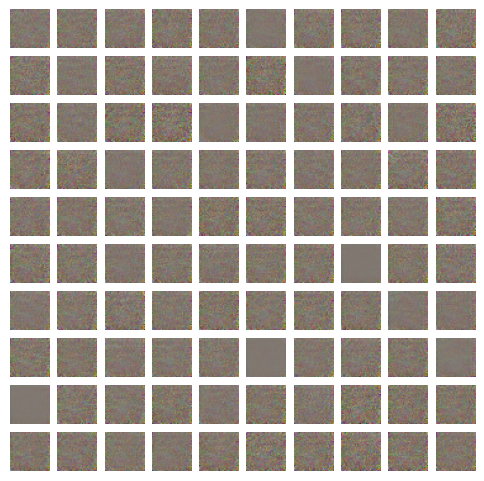

In [12]:
user.plot(reconstructed_user_data)

### Notes:
* Label recovery works reasonably well in this example. Especially as labels are unique in the default settings.
* The interesting part here is not that most images are unrecognizable (they are), but that a few select images do get reconstructed very well.
* Also note that this model is quite large for an experiment on CIFAR-100